In [57]:
import pandas as pd
import numpy as np
import re
from dataclasses import dataclass
import sys, os
from tqdm.notebook import tqdm

In [58]:
contents = pd.read_csv('./data/dat_bencmarking_combined.csv')
contents.head()

,epi,tcr,binding
0,WTYRPEVRGVW,CASSSGTGPSENEAYF,0
1,KFPRGQGVPI,CASSKRALGDTQYF,1
2,GPGHKARVL,CASSFGGATGPGELFF,1
3,TSTLAEQIAW,CASSPGVGNTEAFF,1
4,SWISDIRAGTAPLCRNHIKSSCSLI,CAVSAGSSGALRTQHF,0


In [59]:
# Process tcr and epitope sets
tcr_set = contents['tcr'].unique()
epi_set = contents['epi'].unique()
tcr_rank = np.arange(2, len(tcr_set)+2)
epi_rank = np.arange(3, len(epi_set)+3)
tcr_pd = pd.DataFrame({"tcr_set": tcr_set, "tcr_rank": tcr_rank})
epi_pd = pd.DataFrame({"epi_set": epi_set, "epi_rank": epi_rank})
tcr_pd.to_csv('./data/tcr.csv', index=False, header=False, sep='\t')
epi_pd.to_csv('./data/epitopes.csv', index=False, header=False, sep='\t')
training_set = pd.read_csv('./data/dat_bencmarking_combined.csv')


In [60]:
def load_data_split(x_pep, x_tcr, args):

    split_type = args.split
    idx_test_remove = None
    idx_test = None
    idx_train = None

    if split_type == 'random':
        n_total = len(x_pep)
    elif split_type == 'epitope':
        unique_peptides = np.unique(x_pep)
        n_total = len(unique_peptides)
    elif split_type == 'tcr':
        unique_tcrs = np.unique(x_tcr)
        n_total = len(unique_tcrs)

    indexfile = re.sub('.csv', f'_{split_type}_data_shuffle.txt', args.infile)
    idx_shuffled = np.loadtxt(indexfile, dtype=np.int32)

    # Determine data split from folds
    n_test = int(round(n_total / args.n_fold))
    n_train = n_total - n_test

    # Determine position of current test fold
    test_fold_start_index = args.idx_test_fold * n_test
    test_fold_end_index = (args.idx_test_fold + 1) * n_test

    if split_type == 'random':
        # Split data evenly among evenly spaced folds
        # Determine if there is an outer testing fold
        if args.idx_val_fold < 0:
            idx_test = idx_shuffled[test_fold_start_index:test_fold_end_index]
            idx_train = list(set(idx_shuffled).difference(set(idx_test)))
        else:
            validation_fold_start_index = args.idx_val_fold * n_test
            validation_fold_end_index = (args.idx_val_fold + 1) * n_test
            idx_test_remove = idx_shuffled[test_fold_start_index:test_fold_end_index]
            idx_test = idx_shuffled[validation_fold_start_index:validation_fold_end_index]
            idx_train = list(set(idx_shuffled).difference(set(idx_test)).difference(set(idx_test_remove)))
    elif split_type == 'epitope':
        if args.idx_val_fold < 0:
            idx_test_pep = idx_shuffled[test_fold_start_index:test_fold_end_index]
            test_peptides = unique_peptides[idx_test_pep]
            idx_test = [index for index, pep in tqdm(enumerate(x_pep)) if pep in test_peptides]
            idx_train = list(set(range(len(x_pep))).difference(set(idx_test)))
        else:
            validation_fold_start_index = args.idx_val_fold * n_test
            validation_fold_end_index = (args.idx_val_fold + 1) * n_test
            idx_test_remove_pep = idx_shuffled[test_fold_start_index:test_fold_end_index]
            test_remove_peptides = unique_peptides[idx_test_remove_pep]
            idx_test_pep = idx_shuffled[validation_fold_start_index:validation_fold_end_index]
            test_peptides = unique_peptides[idx_test_pep]
            idx_test = [index for index, pep in tqdm(enumerate(x_pep)) if pep in test_peptides]
            idx_test_remove = [index for index, pep in enumerate(x_pep) if pep in test_remove_peptides]
            idx_train = list(set(range(len(x_pep))).difference(set(idx_test)).difference(set(idx_test_remove)))
    elif split_type == 'tcr':
        if args.idx_val_fold < 0:
            idx_test_tcr = idx_shuffled[test_fold_start_index:test_fold_end_index]
            test_tcrs = unique_tcrs[idx_test_tcr]
            idx_test = [index for index, tcr in tqdm(enumerate(x_tcr)) if tcr in test_tcrs]
            idx_train = list(set(range(len(x_tcr))).difference(set(idx_test)))
        else:
            validation_fold_start_index = args.idx_val_fold * n_test
            validation_fold_end_index = (args.idx_val_fold + 1) * n_test
            idx_test_remove_tcr = idx_shuffled[test_fold_start_index:test_fold_end_index]
            test_remove_tcrs = unique_tcrs[idx_test_remove_tcr]
            idx_test_tcr = idx_shuffled[validation_fold_start_index:validation_fold_end_index]
            test_tcrs = unique_tcrs[idx_test_tcr]
            idx_test = [index for index, tcr in tqdm(enumerate(x_tcr)) if tcr in test_tcrs]
            idx_test_remove = [index for index, tcr in enumerate(x_tcr) if tcr in test_remove_tcrs]
            idx_train = list(set(range(len(x_tcr))).difference(set(idx_test)).difference(set(idx_test_remove)))

    return idx_train, idx_test, idx_test_remove

# TCR

In [61]:
with open('./data/dat_bencmarking_combined_tcr_data_shuffle.txt', 'r') as f:
	lines_tcr = f.readlines()
lines_tcr = [int(l.rstrip('\n')) for l in lines_tcr]
train_tcr = np.array(lines_tcr)
test_tcr = np.array(set(np.arange(len(training_set))) - set(train_tcr))

@dataclass
class Args:
    split: str = 'tcr'
    infile = str = './data/dat_bencmarking_combined.csv'
    n_fold: int = 5
    idx_test_fold: int = 0
    idx_val_fold: int = -1

id_train_tcr, id_test_tcr, id_test_rmv_tcr = load_data_split(training_set['epi'], training_set['tcr'], Args)

0it [00:00, ?it/s]

In [62]:
train_dataset_tcr = training_set.iloc[id_train_tcr]
test_dataset_tcr = training_set.iloc[id_test_tcr]
tcr_readin = pd.read_csv('./data/tcr.csv', header=None, sep='\t')
tcr_dict = dict(zip(tcr_readin[0], tcr_readin[1]))
epi_readin = pd.read_csv('./data/epitopes.csv', header=None, sep='\t')
epi_dict = dict(zip(epi_readin[0], epi_readin[1]))

train_dataset_tcr_ready = pd.DataFrame({'ligand_name': train_dataset_tcr['epi'].map(epi_dict).fillna(-1),
										'sequence_id': train_dataset_tcr['tcr'].map(tcr_dict).fillna(-1),
										'label': train_dataset_tcr['binding']})
train_dataset_tcr_ready.reset_index(drop=True, inplace=True)
# train_dataset_tcr.loc[:,'tcr_idx'] = train_dataset_tcr['tcr'].map(tcr_dict).fillna(-1)
# train_dataset_tcr.loc[:,'epi_idx'] = train_dataset_tcr['epi'].map(epi_dict).fillna(-1)
# train_dataset_tcr.loc[:,'idx'] = np.arange(len(train_dataset_tcr))
# train_dataset_tcr.set_index('idx', inplace=True)
test_dataset_tcr_ready = pd.DataFrame({'ligand_name': test_dataset_tcr['epi'].map(epi_dict).fillna(-1),
										'sequence_id': test_dataset_tcr['tcr'].map(tcr_dict).fillna(-1),
										'label': test_dataset_tcr['binding']})
test_dataset_tcr_ready.reset_index(drop=True, inplace=True)
# test_dataset_tcr_ready.loc[:,'idx'] = np.arange(len(test_dataset_tcr_ready))
# test_dataset_tcr_ready.set_index('idx', inplace=True)
train_dataset_tcr_ready.to_csv('./data/tcr_train_split.csv', index=True, sep=',')
test_dataset_tcr_ready.to_csv('./data/tcr_test_split.csv', index=True, sep=',')
# test_dataset_tcr.loc[:,'tcr_idx'] = test_dataset_tcr['tcr'].map(tcr_dict).fillna(-1)
# test_dataset_tcr.loc[:,'epi_idx'] = test_dataset_tcr['epi'].map(epi_dict).fillna(-1)
# test_dataset_tcr.loc[:,'idx'] = np.arange(len(test_dataset_tcr))
# test_dataset_tcr.set_index('idx', inplace=True)

# train_csv_tcr = train_dataset_tcr[['epi_idx', 'tcr_idx', 'binding']]
# test_csv_tcr = test_dataset_tcr[['epi_idx', 'tcr_idx', 'binding']]
# train_csv_tcr.to_csv('./data/tcr_train_split.csv', index=True, header=['ligand_name','sequence_id','label'], sep=',')
# test_csv_tcr.to_csv('./data/tcr_test_split.csv', index=True, header=['ligand_name','sequence_id','label'], sep=',')

# Epitope

In [63]:
with open('./data/dat_bencmarking_combined_tcr_data_shuffle.txt', 'r') as f:
	lines_epi = f.readlines()
lines_epi = [int(l.rstrip('\n')) for l in lines_epi]
train_epi = np.array(lines_epi)
train_epi = np.array(set(np.arange(len(training_set))) - set(train_epi))

@dataclass
class Args:
    split: str = 'epitope'
    infile = str = './data/combined_dataset_repTCRs.csv'
    n_fold: int = 5
    idx_test_fold: int = 0
    idx_val_fold: int = -1

id_train_epi, id_test_epi, id_test_rmv_epi = load_data_split(training_set['epi'], training_set['tcr'], Args)

FileNotFoundError: ./data/combined_dataset_repTCRs_epitope_data_shuffle.txt not found.

In [55]:
train_dataset_epi = training_set.iloc[id_train_epi]
test_dataset_epi = training_set.iloc[id_test_epi]
epi_readin = pd.read_csv('./data/tcr.csv', header=None, sep='\t')
epi_dict = dict(zip(epi_readin[0], epi_readin[1]))
epi_readin = pd.read_csv('./data/epitopes.csv', header=None, sep='\t')
epi_dict = dict(zip(epi_readin[0], epi_readin[1]))

# train_dataset_epi.loc[: ,'tcr_idx'] = train_dataset_epi.iloc['tcr'].map(tcr_dict).fillna(-1)
# train_dataset_epi.loc[: ,'epi_idx'] = train_dataset_epi.iloc['epi'].map(epi_dict).fillna(-1)
# test_dataset_epi.loc[: ,'tcr_idx'] = test_dataset_epi.iloc['tcr'].map(tcr_dict).fillna(-1)
# test_dataset_epi.loc[: ,'epi_idx'] = test_dataset_epi.iloc['epi'].map(epi_dict).fillna(-1)
# test_dataset_tcr.loc[: ,'idx'] = np.arange(len(test_dataset_tcr))
# test_dataset_tcr.set_index('idx', inplace=True)
train_dataset_epi_ready = pd.DataFrame({'ligand_name': train_dataset_epi['epi'].map(epi_dict).fillna(-1),
										'sequence_id': train_dataset_epi['tcr'].map(tcr_dict).fillna(-1),
										'label': train_dataset_epi['binding']})
train_dataset_epi_ready.reset_index(drop=True, inplace=True)



test_dataset_epi_ready = pd.DataFrame({'ligand_name': test_dataset_epi['epi'].map(epi_dict).fillna(-1),
										'sequence_id': test_dataset_epi['tcr'].map(tcr_dict).fillna(-1),
										'label': test_dataset_epi['binding']})
test_dataset_epi_ready.reset_index(drop=True, inplace=True)


train_dataset_epi_ready.to_csv('./data/epi_train_split.csv', index=True, sep=',')
test_dataset_epi_ready.to_csv('./data/epi_test_split.csv', index=True, sep=',')
# train_csv_epi = train_dataset_epi[['epi_idx', 'tcr_idx', 'binding']]
# test_csv_epi = test_dataset_epi[['epi_idx', 'tcr_idx', 'binding']]
# train_csv_epi.to_csv('./data/epi_train_split.csv', index=True, header=['ligand_name','sequence_id','label'], sep=',')
# test_csv_epi.to_csv('./data/epi_test_split.csv', index=True, header=['ligand_name','sequence_id','label'], sep=',')

In [56]:
tcr_readin = pd.read_csv('./data/tcr.csv', header=None, sep='\t')
tcr_dict = dict(zip(tcr_readin[0], tcr_readin[1]))
epi_readin = pd.read_csv('./data/epitopes.csv', header=None, sep='\t')
epi_dict = dict(zip(epi_readin[0], epi_readin[1]))

In [51]:
epi_dict_rev =  dict(zip(epi_readin[1], epi_readin[0]))
tcr_dict_rev =  dict(zip(tcr_readin[1], tcr_readin[0]))

In [52]:
tcr_train_split = pd.read_csv('./data/tcr_train_split.csv', index_col=0)
tcr_test_split = pd.read_csv('./data/tcr_test_split.csv', index_col=0)
train_pred = {epi_dict_rev[row['ligand_name']]+tcr_dict_rev[row['sequence_id']]: row['label']  for index, row in tcr_train_split.iterrows()}
test_pred = {epi_dict_rev[row['ligand_name']]+tcr_dict_rev[row['sequence_id']]: row['label']  for index, row in tcr_test_split.iterrows()}

In [53]:
training_set = pd.read_csv('./data/combined_dataset_repTCRs.csv')
label = {row['epi']+row['tcr']: row['binding']  for index, row in training_set.iterrows()}

In [54]:
for idx, val in enumerate(label):
	try: 
		assert label[val] == train_pred[val]
	except KeyError:
		try:
			assert label[val] == test_pred[val]
		except KeyError:
			print('wrong')
print(idx)

300015


In [57]:
epi_train_split = pd.read_csv('./data/epi_train_split.csv', index_col=0)
epi_test_split = pd.read_csv('./data/epi_test_split.csv', index_col=0)
train_pred = {epi_dict_rev[row['ligand_name']]+tcr_dict_rev[row['sequence_id']]: row['label']  for index, row in epi_train_split.iterrows()}
test_pred = {epi_dict_rev[row['ligand_name']]+tcr_dict_rev[row['sequence_id']]: row['label']  for index, row in epi_test_split.iterrows()}

In [58]:
for idx, val in enumerate(label):
	try: 
		assert label[val] == train_pred[val]
	except KeyError:
		try:
			assert label[val] == test_pred[val]
		except KeyError:
			print('wrong')
print(idx)

300015


# To upper

In [60]:
tcr = pd.read_csv('./data/tcr.csv', header=None, sep='\t')	
tcr[0] = tcr[0].str.upper()
tcr.to_csv('./data/tcr.csv', header=None, sep='\t')	

# Vis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
db = pd.read_csv('./log/tmp_epis_tcrs_atm-tcratm_tcr-tcr_output.csv')

std_list = []
mean_list = []
arr_list = []
for i in range(max(db['Iter'])):
	test = db[db['Iter'] == i+1]
	epo = test[test['TCRs'] != 'WRONGFORMAT']
	# epo = test
	arr = np.array(epo['yhat'].apply(eval).tolist())
	arr_list.append(arr)
	std_list.append(arr.std())
	mean_list.append(arr.mean())
# Generate example data
x = range(1, len(mean_list)+1)
y = mean_list
y_std = std_list  # Mean (example)

# Calculate the mean and standard deviation (for demonstration purposes)
x_tcr = x[:40]
mean_tcr = np.array(y)[:40]
std_tcr = np.array(y_std)[:40]

In [5]:
tt = './log/tmp_epis_tcrs_titanbest_ROC-AUC_bimodal_mca_output.csv'
db = pd.read_csv(tt)

std_list = []
mean_list = []
arr_list = []
for i in range(max(db['Iter'])):
	test = db[db['Iter'] == i+1]
	# epo = test[test['TCRs'] != 'WRONGFORMAT']
	epo = test
	arr = np.array(epo['yhat'].apply(eval).tolist())
	arr_list.append(arr)
	std_list.append(arr.std())
	mean_list.append(arr.mean())
	
x = range(1, len(mean_list)+1)
y = mean_list
y_std = std_list  # Mean (example)

# Calculate the mean and standard deviation (for demonstration purposes)
x_titan = x[:40]
mean_titan = np.array(y)[:40]
std_titan = np.array(y_std)[:40]


In [6]:
tt = './log/tmp_epis_tcrs_ergoergo_tcr_lstm_model_output.csv'
db = pd.read_csv(tt)

std_list = []
mean_list = []
arr_list = []
for i in range(max(db['Iter'])):
	test = db[db['Iter'] == i+1]
	# epo = test[test['TCRs'] != 'WRONGFORMAT']
	epo = test
	arr = np.array(epo['yhat'].apply(eval).tolist())
	arr_list.append(arr)
	std_list.append(arr.std())
	mean_list.append(arr.mean())
	
x = range(1, len(mean_list)+1)
y = mean_list
y_std = std_list  # Mean (example)

# Calculate the mean and standard deviation (for demonstration purposes)
x_ergolstm = x[:40]
mean_ergolstm = np.array(y)[:40]
std_ergolstm = np.array(y_std)[:40]


In [7]:
tt = './log/tmp_epis_tcrs_ergoergo_tcr_ae_model_output.csv'
db = pd.read_csv(tt)

std_list = []
mean_list = []
arr_list = []
for i in range(max(db['Iter'])):
	test = db[db['Iter'] == i+1]
	# epo = test[test['TCRs'] != 'WRONGFORMAT']
	epo = test
	arr = np.array(epo['yhat'].apply(eval).tolist())
	arr_list.append(arr)
	std_list.append(arr.std())
	mean_list.append(arr.mean())
	
x = range(1, len(mean_list)+1)
y = mean_list
y_std = std_list  # Mean (example)

# Calculate the mean and standard deviation (for demonstration purposes)
x_ergoae = x[:40]
mean_ergoae = np.array(y)[:40]
std_ergoae = np.array(y_std)[:40]


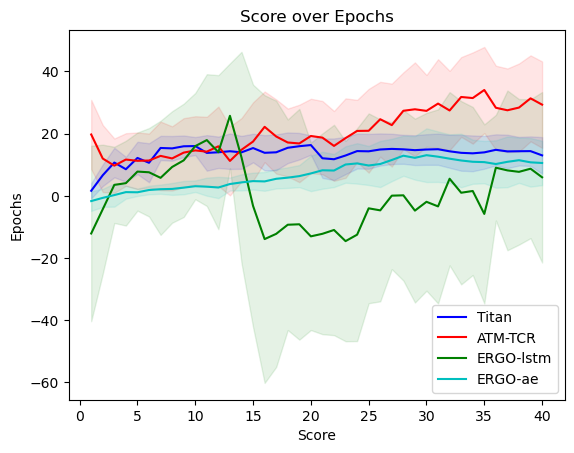

In [8]:


plt.plot(x_titan, mean_titan, label='Titan', color='b')
# Plot the standard deviation as a shaded region
plt.fill_between(x_titan, mean_titan - std_titan, mean_titan + std_titan, color='b', alpha=0.1)
plt.plot(x_tcr, mean_tcr, label='ATM-TCR', color='r')
# Plot the standard deviation as a shaded region
plt.fill_between(x_tcr, mean_tcr - std_tcr, mean_tcr + std_tcr, color='r', alpha=0.1)

plt.plot(x_ergolstm, mean_ergolstm, label='ERGO-lstm', color='g')
# Plot the standard deviation as a shaded region
plt.fill_between(x_ergolstm, mean_ergolstm - std_ergolstm, mean_ergolstm + std_ergolstm, color='g', alpha=0.1)

plt.plot(x_ergoae, mean_ergoae, label='ERGO-ae', color='c')
# Plot the standard deviation as a shaded region
plt.fill_between(x_ergoae, mean_ergoae - std_ergoae, mean_ergoae + std_ergoae, color='c', alpha=0.1)

# Add labels and title
plt.title("Score over Epochs")
plt.xlabel("Score")
plt.ylabel("Epochs")



# Show legend
plt.legend()
# Show the plot
plt.show()

In [99]:
len(mean_titan)


40

In [9]:
metric = './metrics/dat_benchmarking_final.csv'
db = pd.read_csv(metric)
methods = ['yhat_catELMo', 'yhat_pite', 'yhat_titan',
       'yhat_atmtcr', 'yhat_ergolstm', 'yhat_ergoae']
rate = []
for method in methods:
	val = db[method].apply(eval).apply(lambda x: x[0])
	neg = val[val <=0]
	rate.append(len(neg) / len(val))



In [11]:
db[method].apply(eval).apply(lambda x: x[0])

0      -4.284209
1      -1.189537
2      -4.511186
3      -4.613606
4      -0.692551
          ...   
7675    2.175501
7676    1.014653
7677    1.240584
7678    1.544428
7679    1.415443
Name: yhat_ergoae, Length: 7680, dtype: float64

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 480))
# Generate some discrete example data
x = np.arange(7680)  # Index values
# Generate some example labels (3 different labels: 0, 1, 2)

# Define colors and markers for each label
colors = {0: 'r', 1: 'g', 2: 'b', 3:'c', 4: 'y', 5: 'm'}

# Create the scatter plot
for idx, method in enumerate(methods):
    plt.barh(x, db[method].apply(eval).apply(lambda x: x[0]), color=colors[idx], label=f'{method}', alpha=0.8)

# Add labels and title
plt.title("Scatter Plot for Multiple Labeled Data")
plt.xlabel("Index (x)")
plt.ylabel("Value (y)")

# Add grid lines
plt.grid(True)

# Show legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
metric = './metrics/dat_benchmarking_final.csv'
db = pd.read_csv(metric)
# Plot for ‘yhat_catELMo’ and ‘yhat_pite’
df_downsampled = db


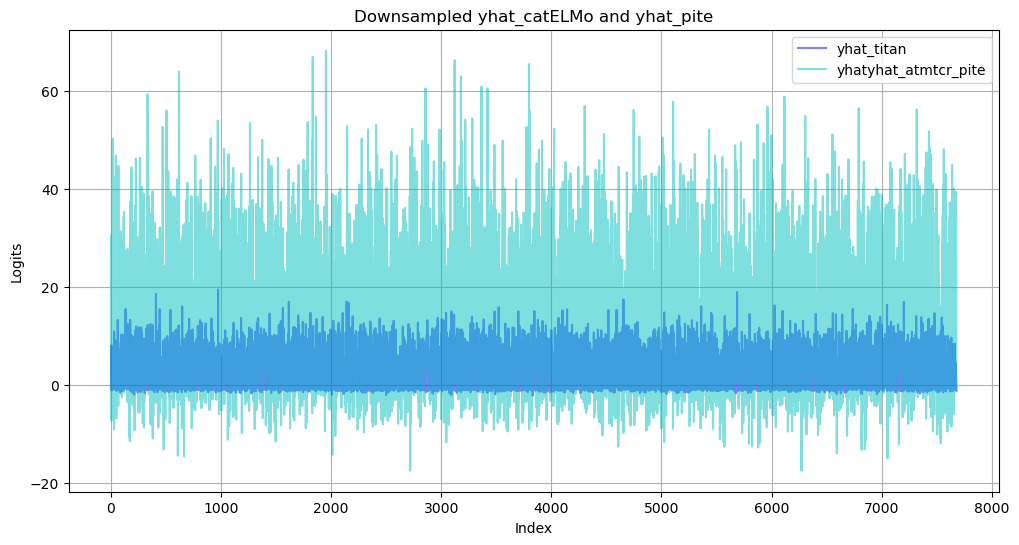

In [42]:

plt.figure(figsize=(12, 6))
# plt.plot(df_downsampled['yhat_catELMo'].apply(eval).apply(lambda x: x[0]), label='yhat_catELMo', color='blue', alpha=0.5)
# plt.plot(df_downsampled['yhat_pite'].apply(eval).apply(lambda x: x[0]), label='yhat_pite', color='red', alpha=0.5)
plt.plot(df_downsampled['yhat_titan'].apply(eval).apply(lambda x: x[0]), label='yhat_titan', color='b', alpha=0.5)
plt.plot(df_downsampled['yhat_atmtcr'].apply(eval).apply(lambda x: x[0]), label='yhatyhat_atmtcr_pite', color='c', alpha=0.5)
# plt.plot(df_downsampled['yhat_ergolstm'].apply(eval).apply(lambda x: x[0]), label='yhat_ergolstm', color='m', alpha=0.5)
# plt.plot(df_downsampled['yhat_ergoae'].apply(eval).apply(lambda x: x[0]), label='yhat_ergoae', color='y', alpha=0.5)

plt.xlabel('Index')
plt.ylabel('Logits')
plt.title('Downsampled yhat_catELMo and yhat_pite')
plt.legend()
plt.grid(True)
# Show plot
plt.show()

In [37]:
df_downsampled['yhat_catELMo'].apply(eval).apply(lambda x: x[0])

0       11.656314
1       22.087420
2       19.625666
3       26.504938
4       16.074224
          ...    
7675    -2.975493
7676     3.406330
7677     2.813263
7678     4.367562
7679     2.974669
Name: yhat_catELMo, Length: 7680, dtype: float64

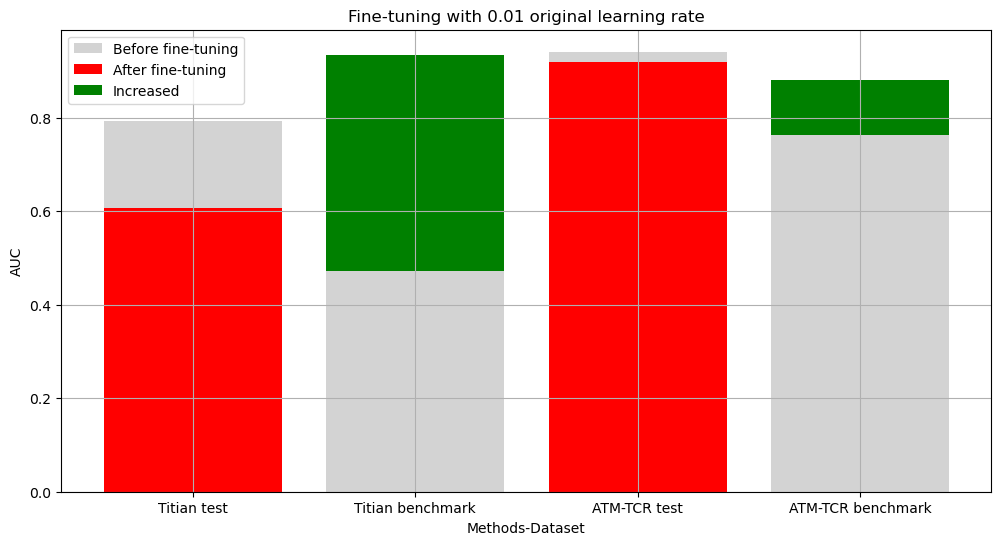

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some discrete example data (current values and previous reference values)
benchmark = ['Titian test', 'Titian benchmark', 'ATM-TCR test', 'ATM-TCR benchmark']  # Indices (0, 1, 2, ..., 29)
y_reference = np.array([0.793, 0.472, 0.941, 0.762])  # Current values
y = np.array([0.607, 0.933, 0.919, 0.881])  # Reference (previous) values

import matplotlib.pyplot as plt
import numpy as np

# Provided data
# benchmark = ['Titian test', 'Titian benchmark', 'ATM-TCR test', 'ATM-TCR benchmark']  # Benchmark labels
# y_reference = np.array([0.793, 0.472, 0.941, 0.762])  # Reference values
# y = np.array([0.607, 0.933, 0.919, 0.881])  # Current values

# Identify the bars that have dropped or increased
dropped_mask = y < y_reference  # Where the values have dropped
increased_mask = y > y_reference  # Where the values have increased

# Calculate the difference between the reference and current values
dropped_values = y_reference - y  # Difference when values dropped

# Create a single figure
plt.figure(figsize=(12, 6))

# Plot the dropped portion (blank or light color)
plt.bar(np.array(benchmark), y_reference, color='lightgray', label='Before fine-tuning')

# # Plot the remaining portion (colored) for dropped values
plt.bar(np.array(benchmark)[dropped_mask], y[dropped_mask], color='r', label='Decreased after fine-tuning')

# # Plot the increased portion for increased values
plt.bar(np.array(benchmark)[increased_mask], y[increased_mask]-y_reference[increased_mask], color='g', label='Increased after fine-tuning', bottom=y_reference[increased_mask])

plt.title("Fine-tuning with 0.01 original learning rate")
plt.xlabel("Methods-Dataset")
plt.ylabel("AUC")
plt.grid(True)
plt.legend()
plt.show()

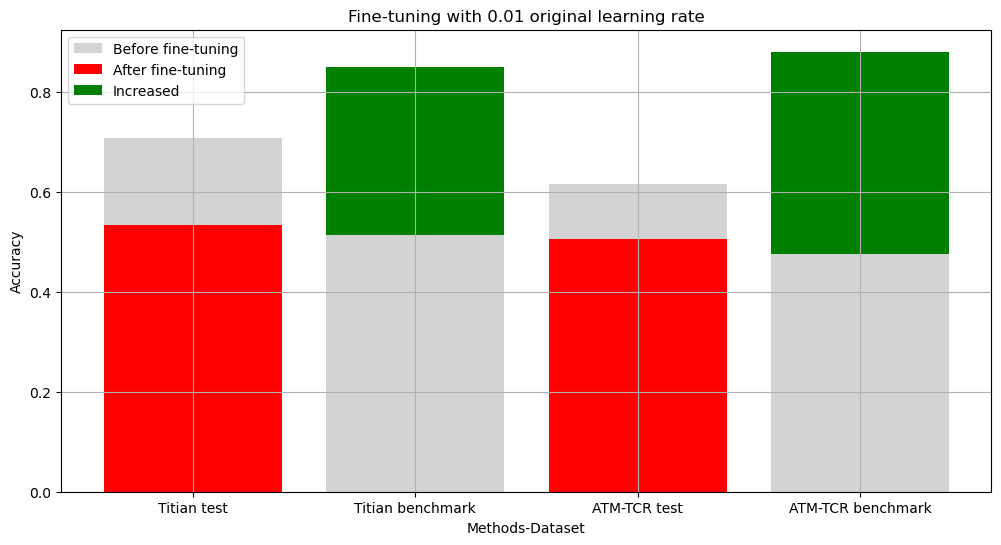

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some discrete example data (current values and previous reference values)
benchmark = ['Titian test', 'Titian benchmark', 'ATM-TCR test', 'ATM-TCR benchmark']  # Indices (0, 1, 2, ..., 29)
y_reference = np.array([0.708, 0.515, 0.616, 0.476])  # Current values
y = np.array([0.534, 0.851, 0.506, 0.881])  # Reference (previous) values

import matplotlib.pyplot as plt
import numpy as np

# Provided data
# benchmark = ['Titian test', 'Titian benchmark', 'ATM-TCR test', 'ATM-TCR benchmark']  # Benchmark labels
# y_reference = np.array([0.793, 0.472, 0.941, 0.762])  # Reference values
# y = np.array([0.607, 0.933, 0.919, 0.881])  # Current values

# Identify the bars that have dropped or increased
dropped_mask = y < y_reference  # Where the values have dropped
increased_mask = y > y_reference  # Where the values have increased

# Calculate the difference between the reference and current values
dropped_values = y_reference - y  # Difference when values dropped

# Create a single figure
plt.figure(figsize=(12, 6))

# Plot the dropped portion (blank or light color)
plt.bar(np.array(benchmark), y_reference, color='lightgray', label='Before fine-tuning')

# # Plot the remaining portion (colored) for dropped values
plt.bar(np.array(benchmark)[dropped_mask], y[dropped_mask], color='r', label='After fine-tuning')

# # Plot the increased portion for increased values
plt.bar(np.array(benchmark)[increased_mask], y[increased_mask]-y_reference[increased_mask], color='g', label='Increased', bottom=y_reference[increased_mask])

plt.title("Fine-tuning with 0.01 original learning rate")
plt.xlabel("Methods-Dataset")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# Prepare strict/epitope split

In [2]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
parent = str(Path.cwd().parent)
sys.path.append(parent)
from tcr_utils.pd_filter import count_entriesByKey

In [3]:
contents = pd.read_csv('data/combined_dataset_repTCRs.csv')
positive = contents[contents['binding'] == 1]

In [4]:
tcr_count = count_entriesByKey(positive, 'TCRs')

In [10]:
tcr_count

,name,count
0,SHAGLGVEQ,35
1,CASTGSYGYTFGSGTRLTVT,33
2,CASSVLNTGELFF,25
3,CASRGQNTGELFF,25
4,CASSLGGYEQYF,18
...,...,...
140670,CASIPWGQGGILEAFF,1
140671,CASKSALAGAGSGELFF,1
140672,CASKSDRNTEAFF,1
140673,CASKSGGSTEAFF,1


In [7]:
epi_count = count_entriesByKey(positive, 'Epitopes')

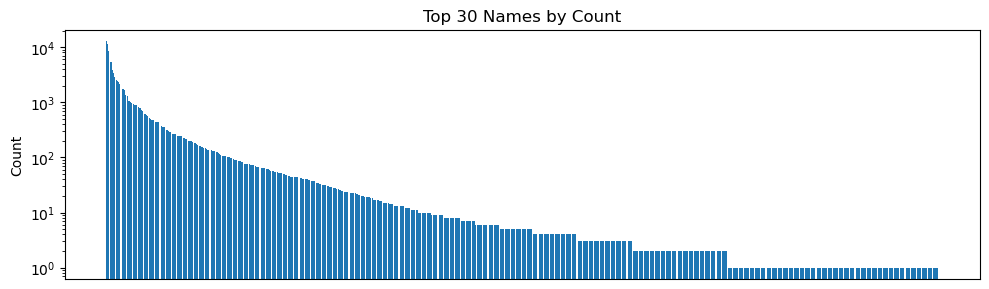

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and you have loaded it
# df = pd.read_csv('path_to_your_data.csv')  # Uncomment if reading from a file

# Sort the DataFrame by 'count' in descending order
df_sorted = epi_count.sort_values(by='count', ascending=False)

# Plot the sorted counts
plt.figure(figsize=(10, 3))
plt.bar(df_sorted['name'], df_sorted['count'])  # Plot only the top 20 for readability
plt.title('Count of TCRs per epitope ')
# plt.xlabel('Name')
plt.ylabel('Count')
plt.xticks([])  # Hide x-axis labels
# plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.yscale('log')  # Use a logarithmic scale if needed
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

ValueError: `bins` must increase monotonically, when an array

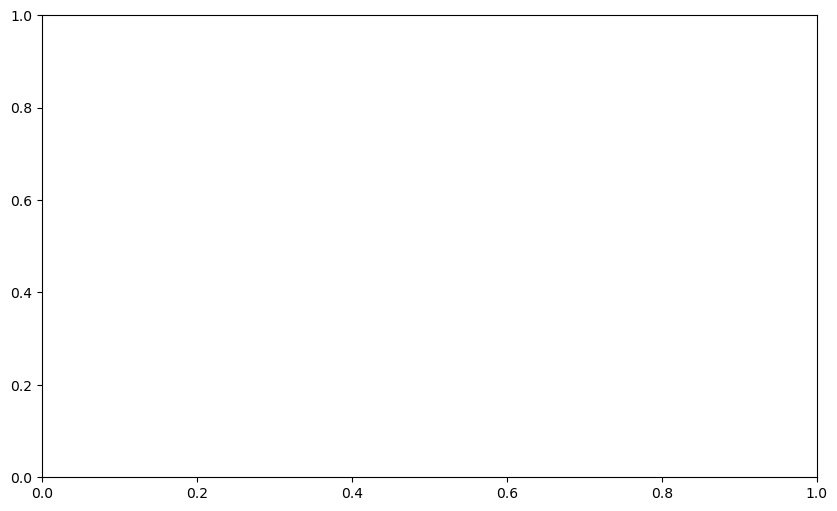

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df and you have loaded it
# df = pd.read_csv('path_to_your_data.csv')  # Uncomment if reading from a file

# Sort the DataFrame by 'count' in descending order
df_sorted = epi_count.sort_values(by='count', ascending=False)

# Plot the distribution of the sorted 'count' column
plt.figure(figsize=(10, 6))
plt.hist(range(0, 932), df_sorted['count'].values)  # kde=True adds a smooth curve
plt.title('Distribution of Counts (Sorted)')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.yscale('log')  # Use a logarithmic scale for better visibility
plt.grid(True)
plt.show()

In [13]:
df_sorted['count'].values

array([12940, 11573,  8511,  7318,  5793,  5401,  5325,  3848,  3424,
        2932,  2710,  2568,  2528,  2460,  2358,  2142,  1875,  1794,
        1786,  1751,  1712,  1657,  1379,  1319,  1297,  1281,  1063,
        1038,   995,   985,   980,   968,   925,   900,   892,   876,
         867,   841,   807,   782,   779,   731,   681,   674,   638,
         613,   609,   590,   569,   548,   537,   528,   493,   485,
         484,   476,   470,   451,   444,   437,   435,   432,   418,
         417,   398,   365,   362,   356,   353,   346,   338,   312,
         311,   301,   287,   286,   285,   273,   271,   267,   267,
         266,   261,   252,   248,   248,   244,   244,   243,   236,
         232,   223,   222,   219,   216,   207,   203,   199,   199,
         198,   196,   193,   188,   185,   183,   180,   176,   169,
         169,   164,   164,   161,   157,   152,   151,   149,   148,
         147,   145,   139,   139,   138,   136,   135,   134,   132,
         130,   130,

In [5]:
tcr_count

,name,count
0,SHAGLGVEQ,35
1,CASTGSYGYTFGSGTRLTVT,33
2,CASSVLNTGELFF,25
3,CASRGQNTGELFF,25
4,CASSLGGYEQYF,18
...,...,...
140670,CASIPWGQGGILEAFF,1
140671,CASKSALAGAGSGELFF,1
140672,CASKSDRNTEAFF,1
140673,CASKSGGSTEAFF,1


In [55]:
CASSLGSYEQYF = positive[positive['TCRs'] == 'CASSLGSYEQYF']

In [56]:
CASSLGSYEQYF

,Epitopes,TCRs,binding
3675,GTSGSPIVNR,CASSLGSYEQYF,1
26229,KTAYSHLSTSK,CASSLGSYEQYF,1
35629,KLGGALQAK,CASSLGSYEQYF,1
78827,VQPTESIVRFPNITNLCPF,CASSLGSYEQYF,1
78828,IMLIIFWFSL,CASSLGSYEQYF,1
78829,MIELSLIDFYLCFLAFLLFLVLIML,CASSLGSYEQYF,1
78830,RQIAPGQTGKIADYNYKL,CASSLGSYEQYF,1
78831,FLNGSCGSV,CASSLGSYEQYF,1
78832,SELVIGAVIL,CASSLGSYEQYF,1
78833,MGYINVFAFPFTIYSL,CASSLGSYEQYF,1


In [53]:
CASSLGETQYF = positive[positive['TCRs'] == 'CASSLGETQYF']

# TEST

In [64]:
CASSPMGLSYEQYV = positive[positive['TCRs'] == 'CASSPMGLSYEQYV']

In [65]:
CASSPMGLSYEQYV

,Epitopes,TCRs,binding
37947,AVFDRKSDAK,CASSPMGLSYEQYV,1
37948,KLGGALQAK,CASSPMGLSYEQYV,1


In [66]:
CASSYEGNTEAFF = positive[positive['TCRs'] == 'CASSYEGNTEAFF']

In [67]:
CASSYEGNTEAFF

,Epitopes,TCRs,binding
26853,LVVDFSQFSR,CASSYEGNTEAFF,1
39478,KLGGALQAK,CASSYEGNTEAFF,1


In [69]:
KLGGALQAK = positive[positive['Epitopes'] == 'KLGGALQAK']

In [71]:
KLGGALQAK.to_csv('./KLGGALQAK.csv')